# Imports

In [19]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tqdm.notebook import tqdm

# Introduction to Deep Learning in Python using TensorFlow and Keras

In this section, we are going to explore the tensorflow package by creating a neural network to determine hand written numbers. We will be using the MNIST data set. This is example is like the "hello world" of deep learning. This activity should help us get familiar with deep learning and how we can apply it to our current project. This example will be using a convolutional neural network (CNN). For our project for predicting games, we will use a multilayer perceptron.

In [2]:
import tensorflow as tf

# Get 28x28 images of handwritten digits 0-9
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) =  mnist.load_data()

# Normalize our data
X_train = tf.keras.utils.normalize(X_train)
X_test = tf.keras.utils.normalize(X_test)

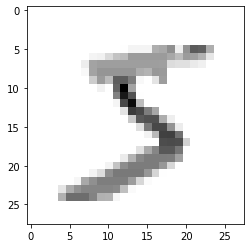

In [3]:
import matplotlib.pyplot as plt

# Show the first image in our training set
plt.imshow(X_train[0], cmap = plt.cm.binary)

plt.show()

In [4]:
# Build the model
model = tf.keras.models.Sequential()

# Add our input layer
model.add(tf.keras.layers.Flatten())

# Add a hidden layers
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))

# Add output layer
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4760 - accuracy: 0.8599
Epoch 2/3
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1103 - accuracy: 0.9660
Epoch 3/3
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0745 - accuracy: 0.9770


In [5]:
validation_loss, validation_accuracy = model.evaluate(X_test, y_test)
print(f"Validation loss: {validation_loss}")
print(f"Validation accuracy: {validation_accuracy}")

313/313 [==============================] - 0s 821us/step - loss: 0.0965 - accuracy: 0.9715
Validation loss: 0.09646031260490417
Validation accuracy: 0.9714999794960022


Consider rewriting this model with the Functional API.
The model's prediction: 7


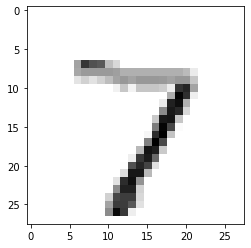

In [6]:
import numpy as np

predictions = model.predict([X_test])
print(f"The model's prediction: {np.argmax(predictions[0])}")

plt.imshow(X_test[0], cmap = plt.cm.binary)
plt.show()

# Loading the Baseball Data

We will start training a neural network using cleaned retrosheet data that we generated when we were training the random forest data. This data has the moving averages for each team over a 10 game span and contains the box score for each game played between the 2014 and 2019 seasons.

In [7]:
dataframe = pd.read_csv("./datasets/cleaned_data/clean_retrosheet.csv")
dataframe.head()

,Date,Number of game,Visiting Team,Home Team,Visiting Team Score,Home Team Score,Home Score SMA,Home Score CMA,Home Score EMA,Home At-bats SMA,...,Visiting Errors EMA,Visiting Passed Balls SMA,Visiting Passed Balls CMA,Visiting Passed Balls EMA,Visiting Double Plays SMA,Visiting Double Plays CMA,Visiting Double Plays EMA,Visiting Triple Plays SMA,Visiting Triple Plays CMA,Visiting Triple Plays EMA
0,20140415,0,NYN,ARI,9,0,3.8,3.800000,3.430552,34.6,...,0.140383,0.0,0.064909,0.008247,0.7,0.813387,0.891189,0.0,0.000000,0.000000e+00
1,20140416,0,NYN,ARI,5,2,3.7,3.454545,2.806815,34.3,...,0.114859,0.0,0.064777,0.006748,0.7,0.811741,0.729154,0.0,0.000000,0.000000e+00
2,20140418,0,SEA,MIA,4,8,5.8,5.800000,6.013663,33.5,...,0.660538,0.0,0.066532,0.000986,1.1,0.907258,1.048140,0.0,0.004032,1.384551e-15
3,20140418,0,CHA,TEX,0,12,4.1,4.100000,5.009391,33.7,...,0.722905,0.1,0.099796,0.105171,1.0,0.942974,1.034505,0.0,0.006110,2.654710e-26
4,20140418,0,SFN,SDN,1,2,3.1,3.100000,2.996733,31.4,...,0.437913,0.1,0.056795,0.087325,1.1,0.900609,0.715089,0.0,0.000000,0.000000e+00


Great! We loaded the data from our previously generated csv. Now let's make a "Target" column in our dataset which reflect which team won the game. This will therefore be a binary classification problem since there are onely two outcomes: Home Team Won, Visiting Team Won. We will represent these outcomes as a 0 and 1 respectively.

In [8]:
data = dataframe.copy()

# Create a column indicating which team won
data["Winner"] = np.where(data["Visiting Team Score"] < data["Home Team Score"], 0, 1)

# Add two more columns: runs EMA / earned runs EMA for both teams
data["Visiting Team Runs over Earned Runs EMA"] = data["Visiting Score EMA"] / data["Visiting Earned Runs EMA"]
data["Home Team Runs over Earned Runs EMA"] = data["Home Score EMA"] / data["Home Earned Runs EMA"]

# Drop features and un-used columns that we know won't be useful
data.drop(data.filter(regex="Triple Plays").columns, axis=1, inplace=True)
data.drop(data.filter(regex="Wild Pitches").columns, axis=1, inplace=True)
data.drop(data.filter(regex="Balks").columns, axis=1, inplace=True)
data.drop(data.filter(regex="Passed Balls").columns, axis=1, inplace=True)
data.drop(data.filter(regex="CMA").columns, axis=1, inplace=True)
data.drop(data.filter(regex="SMA").columns, axis=1, inplace=True)
data.drop(columns=["Date",
                   "Number of game",
                   "Visiting Team",
                   "Home Team",
                   "Visiting Team Score",
                   "Home Team Score"],
          inplace=True)

# Split the data into training sets and test sets
train, test = train_test_split(data, test_size=0.25)
train, val = train_test_split(train, test_size=0.2)

assert train.shape[1] == test.shape[1]

print(f"There are {len(train)} training examples")
print(f"There are {len(val)} validation examples")
print(f"There are {len(test)} test examples")

train.head()

There are 8565 training examples
There are 2142 validation examples
There are 3570 test examples


,Home Score EMA,Home At-bats EMA,Home Hits EMA,Home Doubles EMA,Home Triples EMA,Home Homeruns EMA,Home RBIs EMA,Home Sacrifice Hits EMA,Home Sacrifice Flies EMA,Home Hit-by-pitch EMA,...,Visiting Pitchers Used EMA,Visiting Individual Earned Runs EMA,Visiting Earned Runs EMA,Visiting Putouts EMA,Visiting Assists EMA,Visiting Errors EMA,Visiting Double Plays EMA,Winner,Visiting Team Runs over Earned Runs EMA,Home Team Runs over Earned Runs EMA
10280,3.353644,32.522200,7.416984,1.632670,0.081041,1.289638,3.262920,0.001035,0.023898,0.820715,...,3.907684,4.384777,4.384453,25.791390,8.842905,0.359017,0.634401,1,1.419744,0.821437
6111,6.106279,33.545323,9.502513,3.184348,0.211438,0.915348,5.918764,0.539408,0.133151,0.316173,...,3.669185,4.416369,4.416369,26.029959,11.273914,0.452349,0.840686,0,1.070392,1.762346
3901,5.250114,31.115920,7.614094,1.217520,0.202147,1.700681,5.011738,0.332694,0.259958,0.643532,...,4.386368,4.458291,4.458291,26.499648,10.174089,0.289063,0.855629,1,0.838198,1.736748
3221,3.625674,34.326847,9.144846,2.234143,0.153699,0.583131,3.429705,0.309716,0.208757,0.286969,...,3.423166,3.694481,3.694481,24.275741,8.615106,0.711514,0.726389,1,0.504638,0.839604
13980,3.239487,31.098270,5.978296,1.532655,0.031343,0.648370,2.885493,0.337588,0.162918,0.616445,...,4.678284,6.137648,6.048027,24.747587,8.858856,0.361240,0.734385,0,0.660447,0.739648


# Getting the Data Ready for Tensorflow
Now we have our training set and our test set. Before we can train a model, we must first get the dataframe objects properly ready and also correctly identify the feature columns we will be using.

First, we have to wrap the dataframes with `tf.data`, in order to shuffle and batch the data.

In [9]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('Winner')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

We have now created the input pipeline. Let's call it to see the format of the data it returns. For demonstration purposes, we will enter a small batch size to keep the output readable and also only show the first three features.

In [10]:
train_ds = df_to_dataset(train, batch_size=5)

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys())[:3])
print('A batch of Home Hits EMA:', train_features["Home Score EMA"])
print('A batch of targets:', label_batch )

Every feature: ['Home Score EMA', 'Home At-bats EMA', 'Home Hits EMA']
A batch of Home Hits EMA: tf.Tensor([3.80808061 4.15708968 3.82736415 4.98816833 5.89639859], shape=(5,), dtype=float64)
A batch of targets: tf.Tensor([1 0 1 1 0], shape=(5,), dtype=int32)


In this dataset, all of our features are Numeric. For each Numeric feature, we will have to use a `Normalization()` layer to make sure that the mean of each feature is a 0 and its standard deviation is 1.

In [11]:
# A utility method to create a Normalization Layer
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

In [12]:
home_hits_col = train_features["Home Hits EMA"]
layer = get_normalization_layer("Home Hits EMA", train_ds)
layer(home_hits_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.5030652 ],
       [ 0.8075641 ],
       [-0.14558835],
       [ 0.08598483],
       [ 1.2911866 ]], dtype=float32)>

# Training the Model

We will use the Keras-functional API to build the model since it is more flexible than the tf.keras.Sequential API.

In [13]:
batch_size=64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [14]:
all_inputs = []
encoded_features = []

for header in tqdm(list(train_features.keys()), unit="feature"):
    numeric_column = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_column = normalization_layer(numeric_column)
    all_inputs.append(numeric_column)
    encoded_features.append(encoded_numeric_column)

In [15]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(64, activation="relu")(all_features)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [16]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
134/134 [==============================] - 4s 16ms/step - loss: 0.7294 - accuracy: 0.5373 - val_loss: 0.6919 - val_accuracy: 0.5154
Epoch 2/10
134/134 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5437 - val_loss: 0.6925 - val_accuracy: 0.5145
Epoch 3/10
134/134 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5435 - val_loss: 0.6935 - val_accuracy: 0.5135
Epoch 4/10
134/134 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5370 - val_loss: 0.6949 - val_accuracy: 0.5145
Epoch 5/10
134/134 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.5409 - val_loss: 0.6954 - val_accuracy: 0.5131
Epoch 6/10
134/134 [==============================] - 0s 3ms/step - loss: 0.6778 - accuracy: 0.5462 - val_loss: 0.6953 - val_accuracy: 0.5140
Epoch 7/10
134/134 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.5539 - val_loss: 0.6990 - val_accuracy: 0.5149
Epoch

In [17]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

56/56 [==============================] - 0s 2ms/step - loss: 0.6983 - accuracy: 0.5403
Accuracy 0.5403361320495605


In [18]:
# test_dict = test.to_dict("list")
# print(test.iloc[2])

# input_dict = {name: tf.convert_to_tensor([value[2]]) for name, value in test_dict.items()}
# predictions = model.predict(input_dict)
# prob = tf.nn.sigmoid(predictions[0])
# print(float(prob))

# Assessment of the Training

As we can see, the neural network did not do much better than the SVM model or the Random Forrest Classifier. In order to improve this, we will now try training the data on player stats instead. Mickey Mannella parsed the retrosheet event files (which contain play-by-play files for every game) from retrosheet to get all of individual player stats. For the time being, we will not be including the pitcher statistics. This will be added in later. There is a small number of prepatory steps that need to accomplish before training the neural network on this new data.

# Prepping the Data for Round 2

In [23]:
STARTING_LINEUPS_DIR = './datasets/starting_lineups/'

def get_starting_lineups(directory=STARTING_LINEUPS_DIR):
    """Function that returns a dataframe object of all of starting lineups"""
    
    dataframes = []
    for file in os.listdir(directory):
        dataframes.append(pd.read_csv(os.path.join(directory, file)))

    return pd.concat(dataframes)

In [24]:
get_starting_lineups()

,Unnamed: 0,Game ID,Visiting Team Player 1 ID,Visiting Team Player 2 ID,Visiting Team Player 3 ID,Visiting Team Player 4 ID,Visiting Team Player 5 ID,Visiting Team Player 6 ID,Visiting Team Player 7 ID,Visiting Team Player 8 ID,Visiting Team Player 9 ID,Home Team Player 1 ID,Home Team Player 2 ID,Home Team Player 3 ID,Home Team Player 4 ID,Home Team Player 5 ID,Home Team Player 6 ID,Home Team Player 7 ID,Home Team Player 8 ID,Home Team Player 9 ID
0,0,ARI201403220,puigy001,turnj001,ramih003,gonza003,vanss001,uribj002,ethia001,ellia001,kersc001,polla001,hilla001,goldp001,pradm001,trumm001,montm001,owinc001,parrg001,milew001
1,1,ARI201403230,gordd002,puigy001,ramih003,gonza003,ethia001,ellia001,baxtm001,uribj002,ryu-h001,polla001,hilla001,goldp001,pradm001,montm001,trumm001,parrg001,gregd001,cahit001
2,2,SDN201403300,crawc002,puigy001,ramih003,gonza003,ethia001,uribj002,ellia001,gordd002,ryu-h001,cabre001,denoc001,headc001,gyorj001,alony001,medit001,venaw001,river003,casha001
3,3,ANA201403310,almoa001,millb002,canor001,smoaj001,morrl001,seagk001,saunm001,ackld001,zunim001,calhk001,troum001,pujoa001,hamij003,freed001,ibanr001,kendh001,iannc001,aybae001
4,4,BAL201403310,navad002,pedrd001,ortid001,napom001,carpm001,sizeg001,bogax001,piera001,middw001,markn001,hardj003,jonea003,davic003,cruzn002,wietm001,yound003,flahr001,schoj001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,2424,CHA201909290,reyev001,mercj002,cabrm001,hickj001,rodrr009,stewc002,demet001,greig001,castw003,sancc001,andet001,abrej003,moncy001,jimee001,collz001,castw002,palkd001,engea001
2425,2425,KCA201909290,wadel001,polaj001,sanom001,cronc002,cavej001,schoj001,castj006,torrr001,milli001,merrw001,solej001,dozih001,gorda001,mcbrr001,cuthc001,mejie001,arteh001,dinin001
2426,2426,SEA201909290,semim001,profj001,piscs001,davik003,brows003,phegj001,neuss001,barrf001,bolts001,longs001,crawj002,nolaa002,seagk001,lewik001,narvo001,voged001,smitm007,gordd002
2427,2427,TEX201909290,lemad001,judga001,gardb001,stanm004,torrg001,sancg002,gregd001,urshg001,maybc001,choos001,andre001,calhw001,santd001,odorr001,solan001,guzmr001,deshd002,trevj001
